In [1]:
import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/emnist/emnist-letters-mapping.txt
/kaggle/input/emnist/emnist-letters-test.csv
/kaggle/input/emnist/emnist-mnist-mapping.txt
/kaggle/input/emnist/emnist-digits-train.csv
/kaggle/input/emnist/emnist-bymerge-mapping.txt
/kaggle/input/emnist/emnist-balanced-train.csv
/kaggle/input/emnist/emnist-digits-test.csv
/kaggle/input/emnist/emnist-balanced-test.csv
/kaggle/input/emnist/emnist-mnist-test.csv
/kaggle/input/emnist/emnist-letters-train.csv
/kaggle/input/emnist/emnist-byclass-train.csv
/kaggle/input/emnist/emnist-bymerge-test.csv
/kaggle/input/emnist/emnist-balanced-mapping.txt
/kaggle/input/emnist/emnist-mnist-train.csv
/kaggle/input/emnist/emnist-digits-mapping.txt
/kaggle/input/emnist/emnist-bymerge-train.csv
/kaggle/input/emnist/emnist-byclass-test.csv
/kaggle/input/emnist/emnist-byclass-mapping.txt
/kaggle/input/emnist/emnist_source_files/emnist-digits-test-labels-idx1-ubyte
/kaggle/input/emnist/emnist_source_files/emnist-bymerge-train-labels-idx1-ubyte
/kaggle/input/

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import numpy as np
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from tensorflow.image import resize


In [3]:
train_df = pd.read_csv('/kaggle/input/emnist/emnist-balanced-train.csv', header=None)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train_df.shape


(112800, 785)

In [5]:
X_train = train_df.loc[:, 1:]
y_train = train_df.loc[:, 0]

X_train.shape, y_train.shape

((112800, 784), (112800,))

In [6]:
label_map = pd.read_csv(
    "/kaggle/input/emnist/emnist-balanced-mapping.txt", 
    delimiter=' ', 
    index_col=0, 
    header=None
).squeeze("columns")
label_map.head()


0
0    48
1    49
2    50
3    51
4    52
Name: 1, dtype: int64

In [7]:
label_dictionary = {}
for index, label in enumerate(label_map):
    label_dictionary[index] = chr(label)

label_dictionary

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'n',
 44: 'q',
 45: 'r',
 46: 't'}

In [8]:
# Sample entry number 42
sample_image = X_train.iloc[42]
sample_label = y_train.iloc[42]
sample_image.shape, sample_label


((784,), 23)

Label entry 42: N


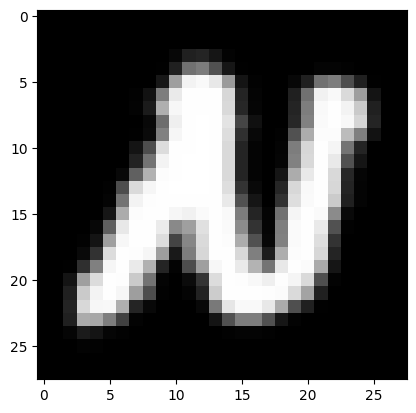

In [9]:
W = 28
H = 28 
def reshape_and_rotate(image):
    W = 28
    H = 28
    image = image.reshape(W, H)
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

print("Label entry 42:", label_dictionary[sample_label])
plt.imshow(reshape_and_rotate(sample_image.values), cmap=plt.cm.gray)
plt.show()


In [10]:
from sklearn.model_selection import train_test_split

number_of_classes=47
# Assuming you have already normalized X_train and one-hot encoded y_train
X_train = np.apply_along_axis(reshape_and_rotate, 1, X_train.values)
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0  # Normalize
y_train = tf.keras.utils.to_categorical(y_train, number_of_classes)

# Split into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42 
)


In [12]:
# Define the preprocessing function
def preprocess_augementation_images(image, label):
    # Resize to 224x224
    image = tf.image.resize(image, (224, 224))
    # Convert grayscale to RGB
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    return image, label
 
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_split, y_train_split))
train_dataset = train_dataset.map(preprocess_augementation_images).batch(64).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_split, y_val_split))
val_dataset = val_dataset.map(preprocess_augementation_images).batch(64).prefetch(tf.data.AUTOTUNE)

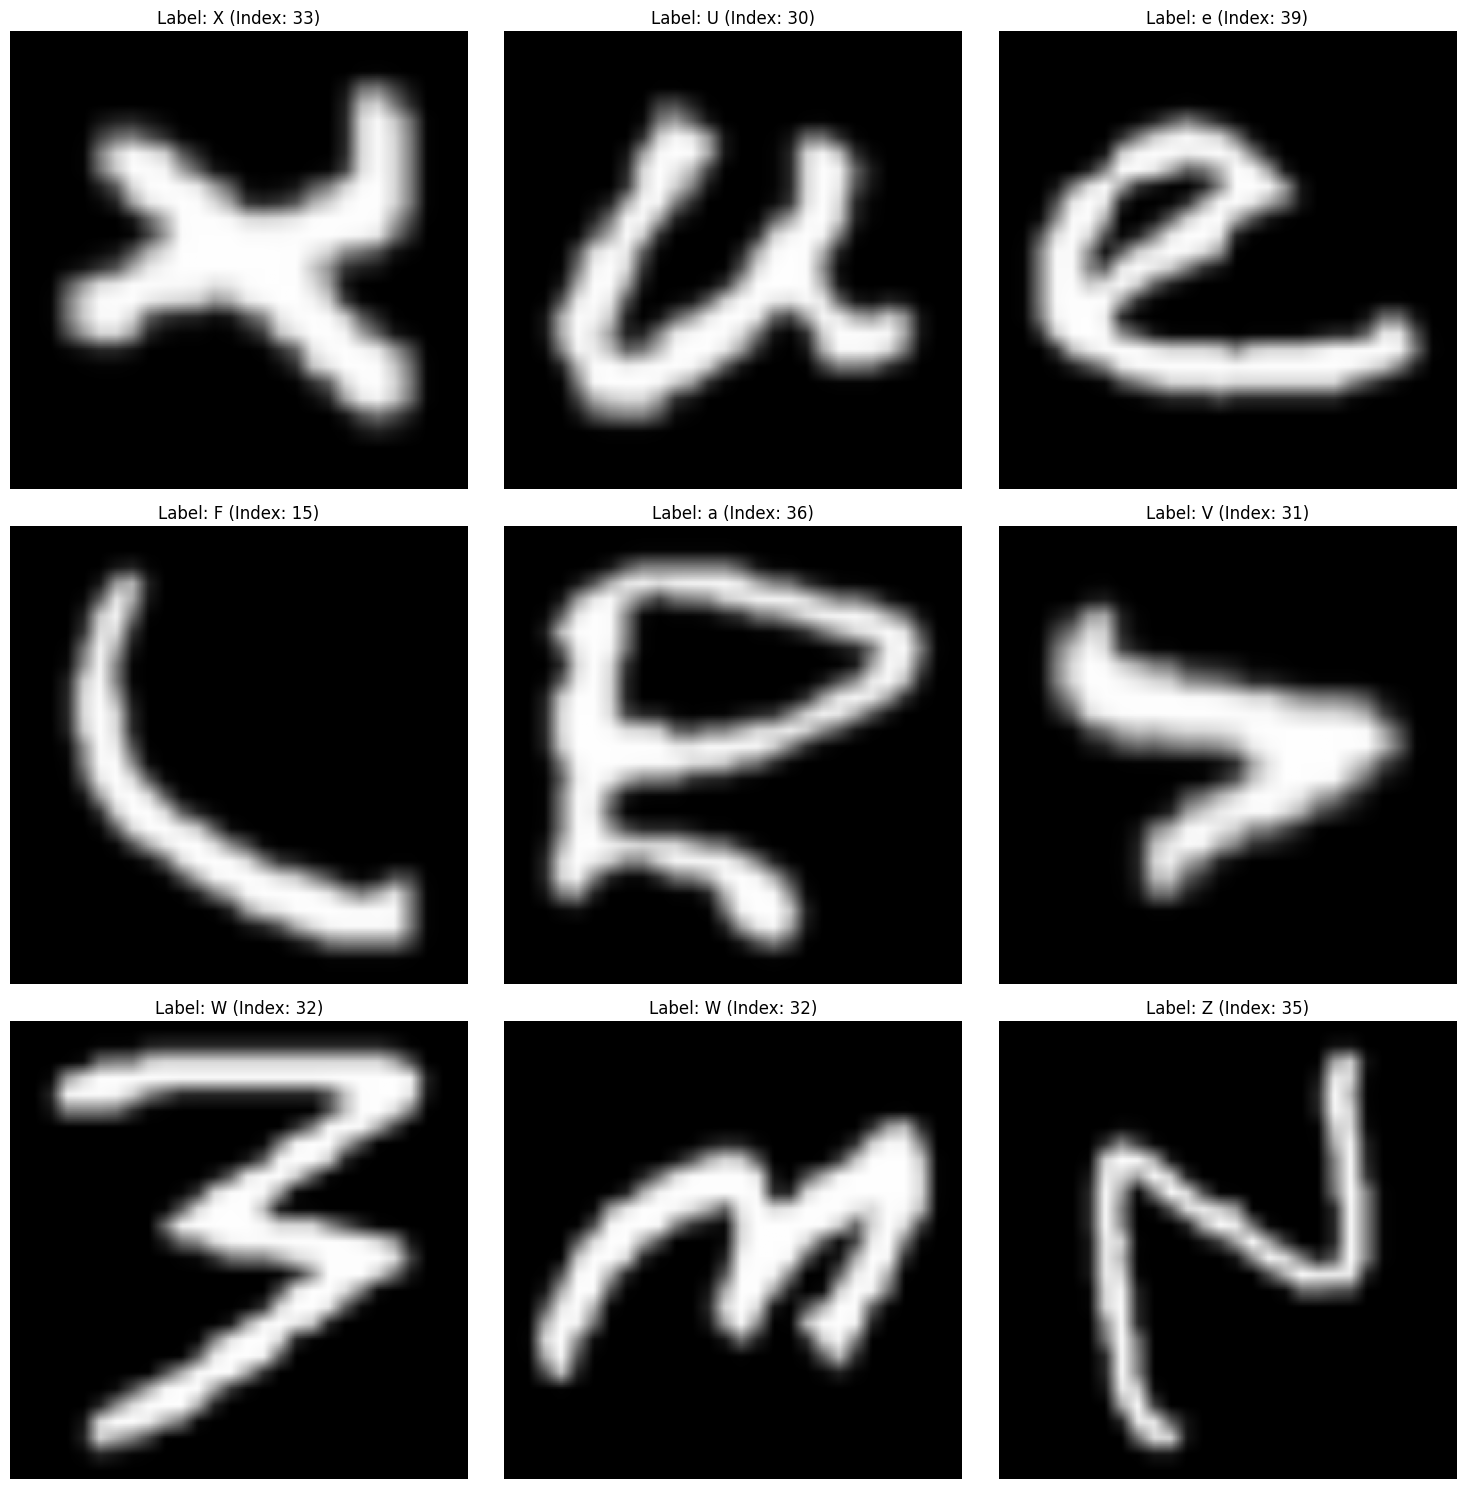

In [13]:
import matplotlib.pyplot as plt
label_dictionary

def visualize_images(dataset, label_dict, num_images=9):
    plt.figure(figsize=(15, 15))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        # Find the index of the max value in the one-hot encoded label
        label_index = np.argmax(label[0])
        
        # Get the corresponding character from the label dictionary
        label_char = label_dict[label_index]
        
        plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy())  # Take first image from batch
        plt.title(f'Label: {label_char} (Index: {label_index})')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
# Visualize training images
visualize_images(train_dataset, label_dictionary)

In [14]:
def identity_block(X, f, filters):
    regularizer = tf.keras.regularizers.l2(1e-4)
    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=regularizer)(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_regularizer=regularizer)(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=regularizer)(X)
    X = BatchNormalization(axis=3)(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [15]:
def convolutional_block(X, f, filters,s=2):
    
    regularizer = tf.keras.regularizers.l2(1e-4)
    # Retrieve Filters
    F1, F2, F3 = filters
    kernel_initializetion= glorot_uniform(seed=0)
    # Save the input value
    X_shortcut = X

    ### MAIN PATH ###
    # First component of main path
    X = Conv2D(F1, (1, 1), strides=(s, s), kernel_initializer=kernel_initializetion, kernel_regularizer=regularizer)(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides=(1, 1), padding='same', kernel_initializer=kernel_initializetion, kernel_regularizer=regularizer)(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides=(1, 1), kernel_initializer=kernel_initializetion, kernel_regularizer=regularizer)(X)
    X = BatchNormalization(axis=3,)(X)

    ### SHORTCUT PATH ###
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), kernel_initializer=kernel_initializetion, kernel_regularizer=regularizer)(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [16]:
ResNet50_Checkpoint = ModelCheckpoint('ResNet50_Best_points.keras',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')

In [17]:
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.initializers import glorot_uniform

# Define input shape and number of classesstride
input_shape = (224, 224, 3)
classes = 47
regularizer = tf.keras.regularizers.l2(1e-4)

kernel_initializetion= glorot_uniform(seed=0)
# Define the input as a tensor with shape input_shape
X_input = Input(input_shape)

# Zero-Padding
X = ZeroPadding2D((3, 3))(X_input)

# Stage 1 - Modify to reduce downsampling
X = Conv2D(64, (3, 3), strides=(1, 1),kernel_initializer=kernel_initializetion, kernel_regularizer=regularizer)(X)
X = BatchNormalization(axis=3)(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

# Stage 3
X = convolutional_block(X, f=3, filters=[128, 128, 512],s=2)
X = identity_block(X, 3, [128, 128, 512])
X = identity_block(X, 3, [128, 128, 512])
X = identity_block(X, 3, [128, 128, 512])

# Stage 4
X = convolutional_block(X, f=3, filters=[256, 256, 1024],s=2)
X = identity_block(X, 3, [256, 256, 1024])
X = identity_block(X, 3, [256, 256, 1024])
X = identity_block(X, 3, [256, 256, 1024])
X = identity_block(X, 3, [256, 256, 1024])
X = identity_block(X, 3, [256, 256, 1024])

# Stage 5
X = convolutional_block(X, f=3, filters=[512, 512, 2048],s=2)
X = identity_block(X, 3, [512, 512, 2048])
X = identity_block(X, 3, [512, 512, 2048])

# AVGPOOL
X = AveragePooling2D((2, 2), name='avg_pool')(X)

# Output layer
X = Flatten()(X)
X = Dense(classes, activation='softmax')(X)

# Create model
ResNet50 = Model(inputs=X_input, outputs=X, name='ResNet50')


optimizer_value = tf.keras.optimizers.Adam(clipvalue=1.0)


ResNet50.compile(optimizer=optimizer_value, loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
ResNet50.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 228, 228,  │      1,792 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 228, 228,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 228, 228,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 114, 114,  │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 57, 57,    │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 57, 57,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 57, 57,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 57, 57,    │    147,584 │ activation_1[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 57, 57,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 57, 57,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 57, 57,    │     66,048 │ activation_2[0][… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 57, 57,    │     33,280 │ max_pooling2d[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 57, 57,    │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 57, 57,    │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 57, 57,    │          0 │ batch_normalizat

 Total params: 27,953,711 (106.63 MB)

 Trainable params: 27,903,407 (106.44 MB)

 Non-trainable params: 50,304 (196.50 KB)

In [ ]:
ResNet50_history = ResNet50.fit(train_dataset, validation_data=val_dataset, epochs=5, callbacks=[ResNet50_Checkpoint])

Epoch 1/5


I0000 00:00:1734461687.563519      89 service.cc:145] XLA service 0x7a23a4002060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734461687.563588      89 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-12-17 18:55:02.834643: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,1024,29,29]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,2048,15,15]{3,2,1,0}, f32[2048,1024,1,1]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-17 18:55:05.869100: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 4.034585193s
Trying algorithm eng0{} for co

 262/1587 ━━━━━━━━━━━━━━━━━━━━ 21:23 969ms/step - accuracy: 0.0575 - loss: 15.1041

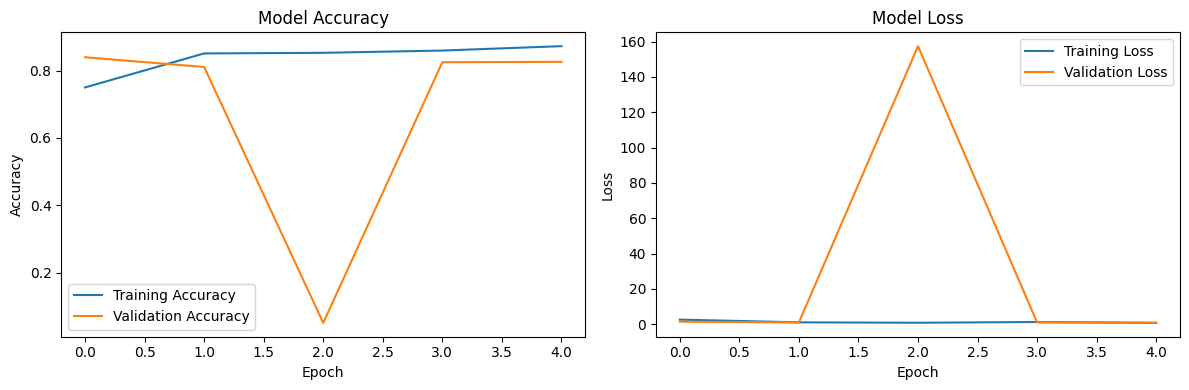

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# 1. Plot Training and Validation Accuracy
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
plot_training_history(ResNet50_history)
    


In [ ]:
def plot_confusion_matrix(model, x_test, y_test, class_names):
    # Predict the values from the test dataset
    y_pred = model.predict(x_test)
    
    # Convert predictions to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot confusion matrix
    plt.figure(figsize=(20, 16))
    
    # heatmap 
    sns.heatmap(cm, 
                annot=True, 
                fmt='d', 
                cmap='Blues', 
                cbar=True,
                xticklabels=class_names, 
                yticklabels=class_names)
    
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)#training_letters
    
    y1 = np.array(training_letter.iloc[:,0].values)
    x1 = np.array(training_letter.iloc[:,1:].values)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()
    



plot_confusion_matrix(model, test_x, test_y, class_names)

In [49]:
from tensorflow.keras.applications import InceptionV3


base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))  

x = base_model(inputs, training=False)   
x = GlobalAveragePooling2D()(x)             
x = Dense(1024, activation='relu')(x)    

outputs = Dense(47, activation='softmax')(x)


mode_inception = Model(inputs, outputs)

mode_inception.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])



In [48]:
Checkpoint_inception = ModelCheckpoint('Best_points_inception.keras',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')

In [50]:
history_inception = mode_inception.fit(train_dataset, validation_data=val_dataset,epochs=10,callbacks=[Checkpoint_inception])

Epoch 1/10
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6505 - loss: 1.2123
Epoch 1: val_accuracy improved from -inf to 0.76605, saving model to Best_points_inception.keras
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 139s 81ms/step - accuracy: 0.6506 - loss: 1.2121 - val_accuracy: 0.7660 - val_loss: 0.7201
Epoch 2/10
1586/1587 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7988 - loss: 0.6067
Epoch 2: val_accuracy improved from 0.76605 to 0.79672, saving model to Best_points_inception.keras
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 120s 76ms/step - accuracy: 0.7988 - loss: 0.6067 - val_accuracy: 0.7967 - val_loss: 0.6091
Epoch 3/10
1586/1587 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8236 - loss: 0.5207
Epoch 3: val_accuracy improved from 0.79672 to 0.80186, saving model to Best_points_inception.keras
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 120s 76ms/step - accuracy: 0.8236 - loss: 0.5207 - val_accuracy: 0.8019 - val_loss: 0.5952
Epoch 4/10
1586/1587 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━

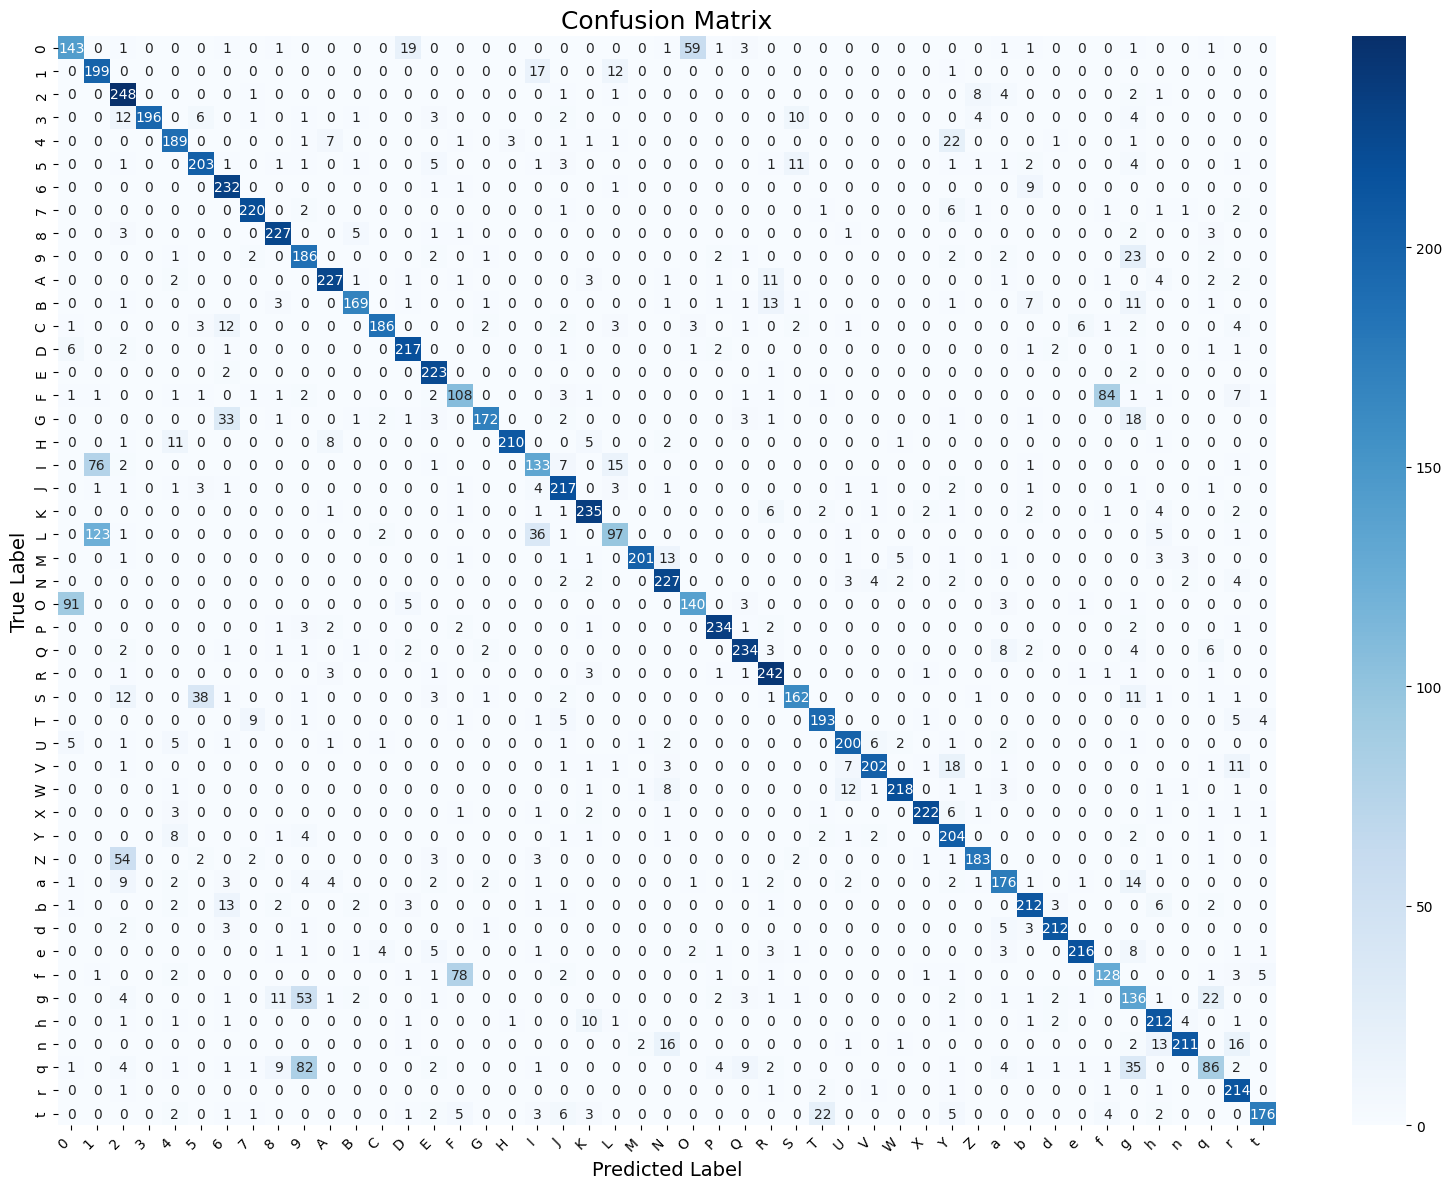

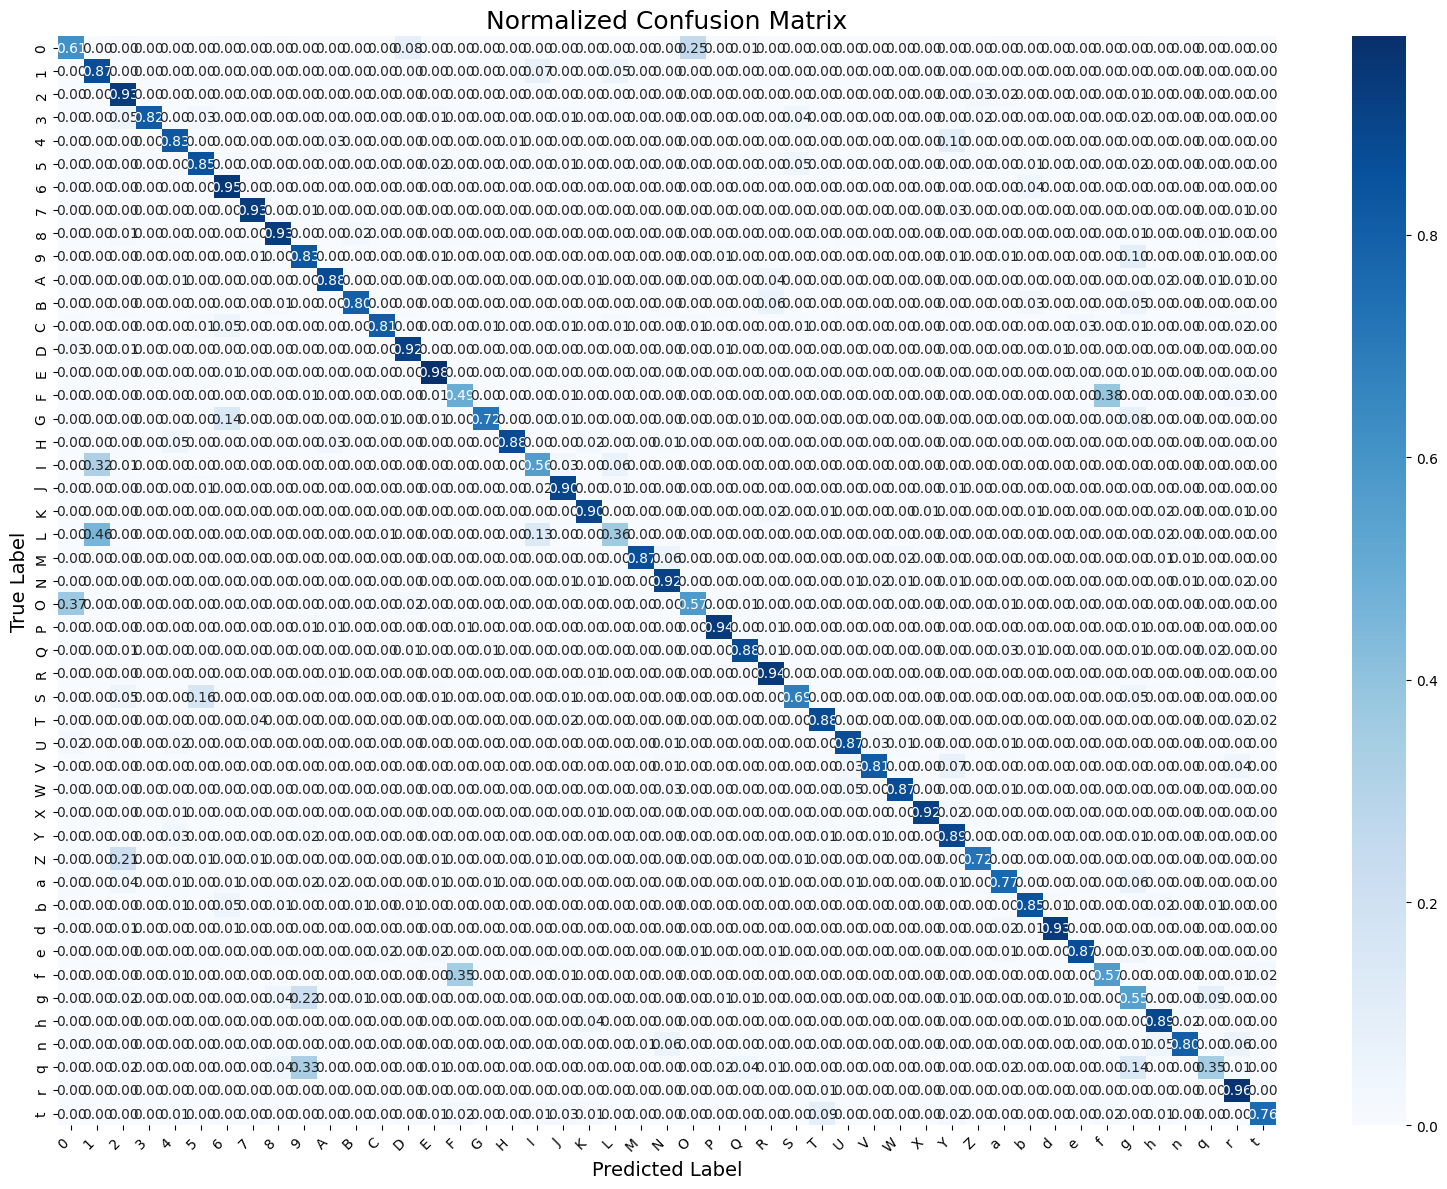

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_tf(model, dataset, class_names):
    # Extract ground truth and predictions from the dataset
    y_true = []
    y_pred = []
    
    for images, labels in dataset:
        # Append ground truth labels
        y_true.append(np.argmax(labels, axis=1))
        preds = model.predict(images)
        y_pred.append(np.argmax(preds, axis=1))
    
    # Concatenate all batches into single arrays
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot confusion matrix
    plt.figure(figsize=(16, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=18)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Plot normalized confusion matrix
    plt.figure(figsize=(16, 12))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=True,
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix', fontsize=18)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Use this function with your validation dataset
plot_confusion_matrix_tf(mode_inception, val_dataset, class_names)
